# Ryan Kast - MIT - 4/29/2021

## Last updated 07/09/2021
    Edited all intrinsic properties functions to consistently use "abf" as the name of the positional argument used to
    identify the pyabf object
    Removed unnecessary cells near the end of the notebook
    Removed the reformat_date and prot_mean functions
    
    KM added in Ryan's block of code that should allow for NeuronID to be generated when DFs are produced 07-12-2022

## This script will:

## 1) Generate lists of all ABF protocols run within a particular dataset (i.e. iterable set of .abf files, such as a pickled list of pyabf.ABF objects)
    Functions (def name_of_function(required arguments/parameters for function)) :
        A) see_used_protocols(pickle)

## 2) Generate pandas dataframes that contain separate columns for each protocol with the rows of the column populated by the filepaths for each abf file that was generated using that particular protocol, or a list of protocols run with just a single protocol of interest
    Functions:
        A) make_protocol_type_DF(protocols_run, pickle)
        B) make_prot_specific_abf_list_subdir(prot)
        C) make_prot_specific_abf_list_pickle(prot, pickle)
 

## 3) Will measure the holding current, access resistance, and membrane resistance for any abf files collected with the membrane test voltage clamp protocol. 
    Functions:
        A) measure_Ra_Rm(protocol_file, celltype = None), Ra and Rm measured on a per sweep basis 
        B) prot_mean_Ra_Rm(DF, celltype = None), calculates the mean Ra and Rm for each protocol


## 4) Will measure H current (Ih) from voltage clamp protocols with negative voltage steps (VC Episodic Ih), will also measure tail currents:
    Functions:
        A) test_measure_Ih(protocol, celltype = None)
        
## 5) Will measure the voltage sag in current clamp protocols with negative current injection (IC Rebound IF)
    Functions:
        A) measure_Vsag(protocol, celltype = None)
        
## 6) Will measure the resting membrane potential (RMP) calculated as mean membrane potential of the first 2 seconds of the CC gap free protocool (RMP1) and the mean membrane potential of the last 2 second of the same CC gap free protocol (RMP2)
    Functions:
        A) measure_RMP(file, celltype = None)
        
## 7) Will measure the capacitance of the cell from a voltage clamp membrane test protocol
    Functions:
        A) measure_Cp(capDF, memtestDF, celltype = None)
        


# NOTE:  NEED pyabf version 2.2.8 (newer versions no module named 'pyabf.abfHeader')

In [1]:
#import all the packages and libraries needed to execute the script
import numpy as np
import pandas as pd
import pickle
import pyabf
import tkinter as tk
import os

## Load Pickled Datasets or pre-processed .csv files to generate pd.DataFrame objects

In [2]:
pickle_nos1 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Nos1_022522_newminipickleMac.pickle", "rb")
pickle_nos1_2 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Nos1_101221_Mac.pickle", "rb")
pickle_spp1_1 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Spp1_022522_newminipickleMac.pickle", "rb")
pickle_spp1_2 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Spp1_062122_newminipickleMac.pickle", "rb")
pickle_spp1_3 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Spp1_101221_Mac.pickle", "rb")
pickle_slc30a3 = open("/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/CompiledAnalysis/PickleJar/Slc30a3_062122_newminipickleMac.pickle", "rb")

Nos1_data = pickle.load(pickle_nos1)
Nos1_data2 = pickle.load(pickle_nos1_2)
Spp1_data1 = pickle.load(pickle_spp1_1)
Spp1_data2 = pickle.load(pickle_spp1_2)
Spp1_data3 = pickle.load(pickle_spp1_3)
Slc30a3_data = pickle.load(pickle_slc30a3)

In [59]:
Spp1_data = Spp1_data1 + Spp1_data2 + Spp1_data3
Nos1_data = Nos1_data + Nos1_data2

In [85]:
set([str(i.abfDateTime.date()) for i in Spp1_data])

{'2020-07-09',
 '2020-07-10',
 '2020-09-22',
 '2020-09-23',
 '2020-09-24',
 '2021-06-15',
 '2021-06-17',
 '2021-06-21',
 '2021-06-28',
 '2021-06-29',
 '2021-06-30',
 '2021-07-01',
 '2021-08-04',
 '2021-08-05',
 '2021-08-06',
 '2021-09-16',
 '2021-09-17',
 '2021-12-23',
 '2022-02-10',
 '2022-02-16',
 '2022-06-13'}

# --------------------Functions for Evaluating pyABF objects in Pickle---------------------

In [104]:
def see_used_protocols(pickle):
    
    """
        This function will generate a list (protocol_list) containing the names of all unique protocols in the list
        of abF_files
        
        Arguments Required: 2
            1. pickle - the pickled dataset containing the ABF file objects from a particular experiment
            
        Returns:
            A list (protocolList) of all unique protocols represented within a pickled 
    """
    
    protocolList = []
    for item in pickle:
        if item.protocol not in protocolList:
            protocolList.append(item.protocol)
    return protocolList

In [105]:
##construct a pandas dataframe that has a column for each protocol run in a pickled ABF dataset
##each column is then filled with the filepaths for data collected with the protocol of that column

def make_protocol_type_DF(protocols_run, pickle):

    """
        This function will generate a pandas dataframe that has a column for each protocol run in a pickled ABF 
        dataset, each column is then filled with the filepaths for data collected with the protocol of that column
        
        Arguments Required: 2
            1. protocols_run - a list of the ABF protocols that were used within a pickled dataset,
                               can be generated using the see_used_protocols() function.
            2. pickle - the pickled dataset containing the ABF file objects from a particular experiment
            
        Returns:
            A new dataframe (protDF) containing the filepaths for all protocols run within the pickled dataset. 
            The column labels in this new dataframe are the protocol names. 
    """
        
    protDF = pd.DataFrame()
    prot_list = []
    for prot in protocols_run:
        file_list = []
        for file in pickle:
            if file.protocol == prot:
                file_list.append(file.abfFilePath)
        protDF.insert(loc=0,value=pd.Series(data=file_list),column=prot)
        
    return protDF

In [106]:
##make a list of all ABF files objects generated with a particular ABF protocol starting from 
##a directory on the computer which containins the Clampex data
def make_prot_specific_abf_list_subdir(prot):
    
    """ 
        This method will prompt user to select a directory and will generate a 
        list of all the ABF files (as pyABF objects) within this directory and any subdirectories
        THAT HAVE BEEN COLLECTED WITH A SPECIFIC PROTOCOL (prot)
        
        Arguments Required: 1 
            1. prot - the name of the Clampex protocol that will serve to identify the ABF files the user wants
                      to be added to the list
                      
        Returns:
            List of the ABF files (abf_list) generated with this specific protocol
    """
    abf_list = [] #make an empty list to hold data file (abf) objects from the indicated neuron above
    
    root = tk.Tk()
    path = tkinter.filedialog.askdirectory(title='Select Folder') # shows dialog box and return the path
    
    #for loop that appends all .abf files in a given directory to the abf_list as pyabf.ABF objects
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.abf'):
                var = pyabf.ABF(os.path.join(subdir, file))
                if var.protocol == prot :
                    abf_list.append(var)   
    root.destroy()
    return abf_list

In [107]:
##make a list of all ABF files objects generated with a particular ABF protocol starting from 
##a directory on the computer which containins the Clampex data
def make_prot_specific_abf_list_pickle(prot, pickle):
    
    """ 
        This method will generate a list of all filepaths containg data collected with a particular Clampex protocol
        
        Arguments Required: 2
            1. prot - the name of the Clampex protocol that will serve to identify the ABF files the user wants
                      to be added to the returned list
            2. pickle - the pickled dataset containing the ABF file objects from a particular experiment
                      
        Returns:
            List of the ABF files (abf_list) generated with this specific protocol
    """
    abf_list = [] #make an empty list to hold data file (abf) objects from the indicated neuron above

    
    #for loop that appends all .abf files in the pickled dataset to the abf_list as pyabf.ABF objects
    for file in pickle:
        if file.protocol == prot:
            abf_list.append(file.abfFilePath)   

    return abf_list

# ----Functions for Extracting Sweepwise Measurements from pyABF objects----

In [108]:
def measure_Ra_Rm(abf, celltype = None):
    
    """
        This function will measure the access resistance (Ra) and membrane resistance (Rm) of the cell
        from any protocol run with the VC membrane test protocol
    
        Arguments Required: 1
            1. abf - the pyABF object to be analyzed (usually collected with VC membrane test)
            
        Optional Argument: 1
            1. celltype - a string variable that indicates what type of cell was recorded (e.g. TRN, Spp1+, or Nos1+)
        
        Returns:
            A new dataframe (memtestDF) containing the identifying information for the mouse, neuron, filepath, and protocol; 
            additionally, for each sweep within the protocol, the dataframe contains the measurement of 
            the holding current, Ra, and Rm.
            
            
    """
   
    
    memtestDF = pd.DataFrame(columns = ['Date', 
                                        'Mouse' , 
                                        'Neuron',
                                        'NeuronID',
                                        'Filename', 
                                        'Protocol', 
                                        'Sweep Number', 
                                        'Holding Current (pA)', 
                                        'Sweep Ra (MOhms)', 
                                        'Sweep Rm (MOhms)'])
 

    #generate a unique identifier for each neuron by merging values from the Neuron and Filename colums, 
    #this is necessary, given that multiple neurons from the same mouse can have the same name if two people are
    #recording on the same day
   

    RKplace = abf.abfFilePath.rfind('/RK')

    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]


        
        
        
    for sweep in abf.sweepList:
        abf.setSweep(sweep) #set the sweep for the current loop
        
        #measure the holding current as the mean current during second epoch
        a = abf.sweepEpochs.p1s[1]
        b = abf.sweepEpochs.p2s[1]
        Ihold = abf.sweepY[a:b].mean() 
        
        #measure the mean steady state current at the end of the voltage step and subtract holding current (third epoch)
        c = abf.sweepEpochs.p2s[2] #define the end of the voltage step
        d = int(c - (abf.dataRate * 0.05)) # subtract the number of desired datapoints leading up to the end of the voltage step, to use as start of time window 
        Imemb = abf.sweepY[d:c].mean() 
        Idiff = Imemb - Ihold
        
        #record the amplitude of the voltage step
        vhold = abf.sweepEpochs.levels[1]
        vstep = abf.sweepEpochs.levels[2]
        stepsize = vstep - vhold
        
        #define the period around the negative voltage step to search for the antipeak of the capacitive transient
        e = int(b - (0.025 * abf.dataRate))
        f = int(b + (0.025 * abf.dataRate))
        Ipeak = abf.sweepY[e:f].min()
        
        #calculate Rm and Ra in MOhms
        Rm = (stepsize/Idiff) * 1000
        Ra = (stepsize/Ipeak) * 1000
        
        #identify the start of neuron name from filepath, which will follow the second to last '/', 
        #and this will be added to the Neuron column of the dataFrame
        Neur = abf.abfFilePath.find('/',-13) 
        
        
        memtestDF = memtestDF.append({'Date': str(abf.abfDateTime.date()), 
                                      'Mouse':' ', 
                                      'Neuron': Neuron,
                                      'Filepath': abf.abfFilePath,
                                      'Filename': abf.abfFilePath[-12:], 
                                      'Protocol': abf.protocol, 
                                      'Sweep Number': int(sweep) + 1, 
                                      'Holding Current (pA)':Ihold, 
                                      'Sweep Ra (MOhms)':Ra, 
                                      'Sweep Rm (MOhms)': Rm}, 
                                      ignore_index = True)
        

    


        memtestDF['NeuronID'] =  memtestDF['Date'] + '/' + Neuron
        
    return memtestDF

In [117]:
def test_measure_Ih(abf, celltype = None):
    
    """
        This function will measure the hyperpolarization induced current recorded with the 'VC episodic (ih)' protocol
    
        Arguments Required: 1
            1. abf - the pyABF object to be analyzed (usually collected with 'VC episodic (ih)' protocol)
            
        Optional Argument: 1
            1. celltype - a string variable that indicates what type of cell was recorded (e.g. TRN, Spp1+, or Nos1+)
        
        Returns:
            A new dataframe (IhDF) containing the identifying information for the mouse, neuron, filepath, abf;
            additionally, for each sweep within the abf, the dataframe contains the measurement of 
            the holding voltage, holding current, voltage step, total current, Ih, tail current peak, and baseline
            adjusted tail current.
    """
    
    Ihlist = []
    Ih_Ra_list = []
    Vsteplist = []
    Vhold = []
    TailCurrent = []
    TailPeakList = []
    HoldingCurrentList = []
    pathlist = []
    TotalImemb = []
    
    IhDF = pd.DataFrame(columns = ['Date', 
                                   'Mouse' , 
                                   'Neuron', 
                                   'Filename', 
                                   'Protocol'])
    
   
     
    
        
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
        
 
    
   
        
    
    for sweep in abf.sweepList:
        
        abf.setSweep(sweep) #set the sweep for the current loop
        
        #These are confirmed correct 9-3-21 RK
        vholding = abf.sweepC[abf.sweepEpochs.p1s[1]]
        Vstep = abf.sweepC[abf.sweepEpochs.p2s[1]]
        Vsteplist.append(Vstep)
        Vhold.append(vholding)
        
        #These are confirmed correct 9-3-21 RK
        a = int(abf.sweepEpochs.p2s[2] - abf.dataRate * 0.05) #define the point 50ms before end of voltage step
        b = abf.sweepEpochs.p2s[2]     #define the end of the voltage step ***RK changed this 09-03-21
        Imemb = abf.sweepY[a:b].mean() #measure the mean current during last 50ms of voltage step

        
        #These are confirmed  correct 9-3-21 RK
        c = abf.sweepEpochs.p1s[1] #define the beginning of the prepulse epoch
        d = abf.sweepEpochs.p2s[1] #define the end of the prepulse epoch ***RK changed this 09-03-21
        Ihold = abf.sweepY[c:d].mean() #measure mean current during prepulse period defined above, and assign as Ihold
       
        Itotal = Imemb - Ihold #measure total current (relative to holding) elicited by voltage step
        TotalImemb.append(Itotal) #append the holding current adjusted max current for each sweep to the TotalImemb list
        
        
        #Measure sweepwise Ra from capacitive transient antipeak current and Ohm's Law (V=IR)
        #Confirmed Working 9-3-21 RK
        aRa = int(abf.sweepEpochs.p2s[1]-(0.025*abf.dataRate))
        bRa = int(abf.sweepEpochs.p2s[1]+(0.025*abf.dataRate))
        captranspeak = abf.sweepY[aRa:bRa].min() - Ihold
        Ih_Ra = (Vstep-vholding)/captranspeak * 1000
        Ih_Ra_list.append(Ih_Ra)
        
        
        #identify the least negative point of current flow within the negative voltage step epoch
        #to be used as a baseline correction for measuring true Ih within each sweep
        Ihump_preIh = abf.sweepY[abf.sweepEpochs.p1s[2]+int(abf.dataRate*0.001):
                                      abf.sweepEpochs.p2s[2]].max()
        
        #Measure true Ih as difference between mean current in last 50ms and least negative current value 
        #observed during voltage step
        Ih = Imemb - Ihump_preIh
        Ihlist.append(Ih)
        
        e = abf.sweepEpochs.p1s[3] #RK: changed this 09-03-21, now truly defines the timepoint return from voltage step to holding voltage
        f = e + int(abf.dataRate*0.100) #RK: changed 09-06-21, now defines tail current window as 100ms following return to holding voltage
        g = abf.sweepEpochs.p2s[4] #define the end of the sweep
        endIhold = abf.sweepY[f:g].mean() 
        
        tailpeak = abf.sweepY[e+int(abf.dataRate*0.001):f].min() #measure the Ih tail current after return to holding voltage
        tailadjust = tailpeak - endIhold #adjust the tail current amplitude measurement by subtracting the holding current from last epoch
    
        TailCurrent.append(tailadjust)
        pathlist.append(abf.abfFilePath)
        
        IhDF = IhDF.append({'Date': str(abf.abfDateTime.date()), 
                            'Mouse':' ', 
                            'Neuron': Neuron, 
                            'Filename': abf.abfFilePath[-12:], 
                            'Protocol': abf.protocol}, 
                           ignore_index = True)
        
        TailPeakList.append(tailpeak)
        HoldingCurrentList.append(Ihold)
    

    IhDF['NeuronID'] = IhDF['Date'] + '/' + Neuron
    IhDF['Filepath'] = pathlist
    IhDF['Sweep Number'] = [swp + 1 for swp in abf.sweepList]
    IhDF['Holding Voltage (mV)'] = Vhold
    IhDF['Voltage Step (mV)'] = Vsteplist
    IhDF['Ih_Ra (MOhms)'] = Ih_Ra_list
    IhDF['Holding Current (pA)'] = HoldingCurrentList
    IhDF['Total Current (pA)'] = TotalImemb
    IhDF['Ih (pA)'] = Ihlist
    IhDF['Tail Current Peak (pA)'] = TailPeakList
    IhDF['Baseline Adjusted Tail Current (pA)'] = TailCurrent
    
    IhDF.insert(0, 'Cell Type', celltype) 
    
    

    
    return IhDF

In [118]:
def measure_Vsag(abf, celltype = None):
    
    """
        This function will measure the sag of the membrane potential (voltage sag) in response to hyperpolarizing
        current injection
    
        Arguments Required: 1
            1. abf - the pyABF object to be analyzed (usually collected with 'VC episodic (ih)' abf)
            
        Optional Argument: 1
            1. celltype - a string variable that indicates what type of cell was recorded (e.g. TRN, Spp1+, or Nos1+)
        
        Returns:
            A new dataframe (vsagDF) containing the identifying information for the mouse, neuron, filepath, abf;
            additionally, for each sweep within the abf, the dataframe contains the measurement of 
            the holding current, current step, pre-step membrane voltage, peak negative membrane voltage, 
            and the voltage sag.
    """
    
    filepathlist = []
    prepulse_current_list = []
    current_step_list = []
    filepathlist = []
    prepulse_voltage_list = []
    vmin_list = []
    vsag_list = []
    
    vsagDF = pd.DataFrame(columns = ['Date', 
                                     'Mouse' , 
                                     'Neuron', 
                                     'Filename', 
                                     'Protocol'])
   


    
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
       

                               
    
    for sweep in abf.sweepList:
        if abf.sweepEpochs.levels[1] < abf.sweepEpochs.levels[0]:
           
            abf.setSweep(sweep) #set the sweep for the current loop
            a = abf.sweepEpochs.p1s[1] #define the beginning of the current injection epoch
            c = abf.sweepEpochs.p2s[1] #define the end of the current injection epoch
            b = int(c - (abf.dataRate * 0.05)) # subtract the number of desired datapoints leading up to the end of the current step, to use as start of time window 
            d = abf.sweepEpochs.p1s[0]
            e = abf.sweepEpochs.p2s[0]
            
            holding_current = abf.sweepC[d:e].mean()
            current_step_list.append(abf.sweepC[a])
            prepulse_current_list.append(holding_current)
        
            vsag = abf.sweepY[b:c].mean()
            vmin = abf.sweepY[a:c].min()
            pre_mV = abf.sweepY[d:e].mean()
            vdiff = vsag - vmin
            vmin_list.append(vmin)
            vsag_list.append(vdiff)
            prepulse_voltage_list.append(pre_mV)
            
            filepathlist.append(abf.abfFilePath)
            
            vsagDF = vsagDF.append({'Date': str(abf.abfDateTime.date()), 
                                    'Mouse':' ', 
                                    'Neuron': Neuron, 
                                    'Filename': abf.abfFilePath[-12:], 
                                    'Protocol': abf.protocol}, 
                                   ignore_index=True)                
        else:
            break
    
    vsagDF['NeuronID'] = vsagDF['Date'] + '/' + Neuron
    vsagDF['Filepath'] = filepathlist
    vsagDF['Sweep Number'] = abf.sweepList
    vsagDF['Holding Current (pA)'] = prepulse_current_list
    vsagDF['Current Step (pA)'] = current_step_list
    vsagDF['Pre-step Membrane Voltage (mV)'] = prepulse_voltage_list
    vsagDF['Peak Negative Membrane Voltage (mV)'] = vmin_list
    vsagDF['Voltage Sag (mV)'] = vsag_list
    vsagDF.insert(0, 'Cell Type', celltype) 
    
    

    
    
    return vsagDF

In [159]:
def stupid_mistake_vsag(protocol, celltype = None):
    
    """
        This function was modified from the measure_vsag function to account for a manually written clampex waveform
        with 'None' name and different number of sweepEpochs
    
        Arguments Required: 1
            1. protocol - the pyABF object to be analyzed (usually collected with 'VC episodic (ih)' protocol)
            
        Optional Argument: 1
            1. celltype - a string variable that indicates what type of cell was recorded (e.g. TRN, Spp1+, or Nos1+)
        
        Returns:
            A new dataframe (vsagDF) containing the identifying information for the mouse, neuron, filepath, protocol;
            additionally, for each sweep within the protocol, the dataframe contains the measurement of 
            the holding current, current step, pre-step membrane voltage, peak negative membrane voltage, 
            and the voltage sag.
    """
    filepathlist = []
    prepulse_current_list = []
    current_step_list = []
    filepathlist = []
    prepulse_voltage_list = []
    vmin_list = []
    vsag_list = []

    vsagDF = pd.DataFrame(columns = ['Date', 
                                     'Mouse' , 
                                     'Neuron', 
                                     'Filename', 
                                     'Protocol'])

    
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
        
        
        

    for sweep in protocol.sweepList:
        
            protocol.setSweep(sweep) #set the sweep for the current loop
            a = protocol.sweepEpochs.p1s[2] #define the beginning of the current injection epoch
            c = protocol.sweepEpochs.p2s[2] #define the end of the current injection epoch
            b = int(c - (protocol.dataRate * 0.05)) # subtract the number of desired datapoints leading up to the end of the current step, to use as start of time window 
            d = protocol.sweepEpochs.p1s[1]
            e = protocol.sweepEpochs.p2s[1]

            holding_current = protocol.sweepC[d:e].mean()
            print(holding_current)
            current_step_list.append(protocol.sweepC[a])
            prepulse_current_list.append(holding_current)

            vsag = protocol.sweepY[b:c].mean()
            vmin = protocol.sweepY[a:c].min()
            pre_mV = protocol.sweepY[d:e].mean()
            vdiff = vsag - vmin
            vmin_list.append(vmin)
            vsag_list.append(vdiff)
            prepulse_voltage_list.append(pre_mV)

            filepathlist.append(protocol.abfFilePath)

            vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()), 
                                    'Mouse':' ', 
                                    'Neuron': Neuron, 
                                    'Filename': protocol.abfFilePath[-12:], 
                                    'Protocol': protocol.protocol}, 
                                   ignore_index=True)                

            
    vsagDF['NeuronID'] = vsagDF['Date'] + '/' + Neuron
    vsagDF['Filepath'] = filepathlist
    vsagDF['Sweep Number'] = protocol.sweepList
    vsagDF['Holding Current (pA)'] = prepulse_current_list
    vsagDF['Current Step (pA)'] = current_step_list
    vsagDF['Pre-step Membrane Voltage (mV)'] = prepulse_voltage_list
    vsagDF['Peak Negative Membrane Voltage (mV)'] = vmin_list
    vsagDF['Voltage Sag (mV)'] = vsag_list
    vsagDF.insert(0, 'Cell Type', celltype)
    
    
        
    
    return vsagDF

In [119]:
def measure_RMP(abf, celltype = None):
    
    RMP1_list = []
    RMP1_maxvolt_list = []
    RMP1_stdev_list = []
    RMP2_list = []
    RMP2_maxvolt_list = []
    RMP2_stdev_list = []
    
    
    
    
            
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
    
    
    
    
    
    dfRMP = pd.DataFrame(columns = ['Date', 
                                     'Mouse' , 
                                     'Neuron', 
                                     'Filename', 
                                     'Protocol'])
      
    
    
    for sweep in abf.sweepList:
        
        abf.setSweep(sweep)
        end = 2 * abf.dataRate
        rmp1 = abf.sweepY[0:end].mean()
        maxvolt1 = abf.sweepY[0:end].max()
        stdev1 = abf.sweepY[0:end].std()
    
        RMP1_list.append(rmp1)
        RMP1_maxvolt_list.append(maxvolt1)
        RMP1_stdev_list.append(stdev1)
    
        second = -2 * abf.dataRate 
        rmp2 = abf.sweepY[second:].mean()
        maxvolt2 = abf.sweepY[second:].max()
        stdev2 = abf.sweepY[second:].std()
    
        RMP2_list.append(rmp2)
        RMP2_maxvolt_list.append(maxvolt2)
        RMP2_stdev_list.append(stdev2)

        #filepathlist.append(protocol.abfFilePath)
            
        dfRMP = dfRMP.append({'Date': str(abf.abfDateTime.date()), 
                                   'Mouse':' ', 
                                   'Neuron': Neuron,
                                   'Filepath' : abf.abfFilePath,
                                   'Filename': abf.abfFilePath[-12:],
                                   'Protocol': abf.protocol}, 
                                   ignore_index=True)  
    

    dfRMP['NeuronID'] = dfRMP['Date'] + '/' + Neuron
    dfRMP['RMP 1'] = RMP1_list
    dfRMP['Max Membrane Voltage 1'] = RMP1_maxvolt_list
    dfRMP['STDEV 1'] = RMP1_stdev_list
    dfRMP['RMP 2'] = RMP2_list
    dfRMP['Max Membrane Voltage 2'] = RMP2_maxvolt_list
    dfRMP['STDEV 2'] = RMP2_stdev_list
    dfRMP.insert(0, 'Cell Type', celltype)
    

    
    return dfRMP

# Functions for Extracting Measures already taken from Clampfit and stored in Pandas DataFrames

In [120]:
def measure_Cp(capDF, memtestDF, celltype = None):
    
    """
    This function will measure the capacitance of the cell as measured with the VC membrane test protocol

    Arguments Required: 2
        1. capDF - a pandas.DataFrame containing the curve fit data and measurments of Tau1, Area1, Tau2, Area2, along with
                    all cell identifying information. IMPORTANT: curve fit data must be manually extracted from Clampex.
        2. memtestDF - a pandas.DataFrame containing the Rm and Ra values (measured from ~20 sweeps 
                    ran in the VC membrane test protocol) along with all cell identying information

    Optional Argument: 1
        1. celltype - a string variable that indicates what type of cell was recorded (e.g. TRN, Spp1+, or Nos1+)

    Returns:
        An updated sweep wise dataframe (capDF) with a capacitance calculated for each sweep. The returned dataframe can be 
        further analyzed by capDF.groupby()['Capacitance (pF)'].median/mean/max/etc.() to produce NeuronLevel results
    """
   
    list_cp = []
    

    
                
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
        
        
    
    
    for i in range(len(capDF)):
        
        #The following if statement had to be created on 08-01-21 because the _xx.abf and _yy.abf files that were present in 
        #the sweep-wise compiled_capacitance.csv (capDF) were not present in the memtestDF and thus caused problems
        if capDF.iloc[i]['NeuronID'] in memtestDF['NeuronID'].unique(): 
            A1 = capDF.iloc[i]['A1']
            Tau1 = capDF.iloc[i]['Tau1']
            A2 = capDF.iloc[i]['A2']
            Tau2 = capDF.iloc[i]['Tau2']
            weightedtau = ((A1 * Tau1) / (A1 + A2)) + ((A2 * Tau2) / (A1 + A2))
            Ra = memtestDF[memtestDF['NeuronID'] == capDF.iloc[i]['NeuronID']].mean()['Sweep Ra (MOhms)']
            Rm = memtestDF[memtestDF['NeuronID'] == capDF.iloc[i]['NeuronID']].mean()['Sweep Rm (MOhms)']
            Cp = weightedtau * ((1/Ra)+(1/Rm)) * 1000
            list_cp.append(Cp)
        else:
            list_cp.append('NaN')

    capDF['NeuronID'] = capDF['Date'] + '/' + Neuron
    capDF['Capacitance (pF)'] = list_cp
    capDF['Capacitance (pF)'] = pd.to_numeric(capDF['Capacitance (pF)'], errors = 'coerce')
    #capDF.insert(0, 'Cell Type', celltype)
        


    
    return capDF

In [121]:
def make_IF_curve(DF):
    RegionList = []
    Datelist = []
    CellTypelist = []
    Filelist = []
    IDlist = []
    CurrentList = []
    Spikeslist = []
    NeuronIDlist = []
    Regioncelltypelist = []
    
    
      
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
        
    
    
    
    
        
    for iden in DF[DF['NeuronID'].notnull()]['NeuronID'].unique().tolist():
        DFsub = DF[DF['NeuronID']==iden]
        
        for num in range(1,17):
            CurrentList.append(num*50)
            CellTypelist.append(DFsub['Cell Type'].iloc[0])
            RegionList.append(DFsub['Region'].iloc[0])
            IDlist.append(iden)
            Datelist.append(DFsub['Date'].iloc[0])
            Filelist.append(DFsub['File'].iloc[0])
            Neuronlist.append(DFsub['Neuron'].iloc[0])
            Regioncelltypelist.append(DFsub['Region_CellType'].iloc[0])
            NeuronIDlist.append(DFsub['NeuronID'].iloc[0])
            if num in list(DFsub['Sweep'].unique()):
                DFsub2 = DFsub[DFsub['Sweep']==num]
                spikecount = len(DFsub2)
                Spikeslist.append(spikecount)
            else:
                Spikeslist.append(0)

    FinalDF = pd.DataFrame()
    
    FinalDF['ID'] = []
    FinalDF['Date'] = Datelist
    FinalDF['Neuron'] = Neuron
    FinalDF['NeuronID'] = FinalDF['Date'] + '/' + Neuron
    FinalDF['File'] = Filelist
    FinalDF['Cell Type'] = CellTypelist
    FinalDF['Region'] = RegionList
    FinalDF['Injected Current (pA)'] = CurrentList
    FinalDF['Spike Count'] = Spikeslist
    FinalDF['Region_CellType'] = Regioncelltypelist
    
    id_list = []
    for item in FinalDF.itertuples():
        id_list.append(str(item[2]) + '/' + str(item[3]) + '/' + str(item[4]))
    FinalDF['ID'] =  id_list
    
    
  
        
    
    
    return FinalDF

In [122]:
#Sweep 4 isolation
def measure_adaptation_index(df):
    
    RegionList = []
    Datelist = []
    CellTypelist = []
    NeuronIDlist = []
    Regioncelltypelist = []

    meanFirstThreeList = []
    meanLastThreeList = []
    FileList = []
    
    X = df[df['Sweep'] == 4]
    
    
        
    RKplace = abf.abfFilePath.rfind('/RK')
    
    if RKplace > 17:
        x = abf.abfFilePath
        Neuron = x[x.rfind('RK'):x.rfind('RK')+5]
    else:
        x = abf.abfFilePath
        Neuron = x[x.rfind('KM'):x.rfind('KM')+5]
        
    
    
    for item in X['NeuronID'].unique():
        
        Y = X[X['NeuronID'] == item]
        FileList.append(item)
        
        meanFirstThree = Y.iloc[1:4]['Inst. Freq. (Hz)'].mean()
        meanFirstThreeList.append(meanFirstThree)
        
        meanLastThree = Y.iloc[-3:]['Inst. Freq. (Hz)'].mean()
        meanLastThreeList.append(meanLastThree)
        
        Datelist.append(Y['Date'].iloc[0])
        CellTypelist.append(Y['Cell Type'].iloc[0])
        RegionList.append(Y['Region'].iloc[0])
        Regioncelltypelist.append(Y['Region_CellType'].iloc[0])
        NeuronIDlist.append(Y['NeuronID'].iloc[0])
            
    DF2 = pd.DataFrame()
    DF2['Neuron'] = Neuron
    DF2['NeuronID'] = DF2['Date'] + '/' + Neuron
    DF2['Date'] = Datelist
    DF2['Cell Type'] = CellTypelist
    DF2['Region'] = RegionList
    DF2['Region_CellType'] = Regioncelltypelist
    DF2['File'] = FileList
    DF2['NeuronID'] = NeuronIDlist
    DF2['Mean First Three'] = meanFirstThreeList
    DF2['Mean Last Three'] = meanLastThreeList
    DF2['Adaptation Index'] = (DF2['Mean Last Three']/DF2['Mean First Three'])


   
    return DF2

# Compile pyABF objects collected with specific Clampex protocols and run the appropriate functions to extract the relevant measures

In [160]:
spp1_ih_df_list = []
spp1_ih_list = []

spp1_vsag_df_list = []
spp1_vsag_list = []

spp1_vsag1_df_list = []
spp1_vsag1_list = []

spp1_ra_rm_df_list = []
spp1_ra_rm_list = []

spp1_RMP_df_list = []
spp1_RMP_list = []

for item in Spp1_data:
    if item.protocol == 'VC episodic (ih)':
        spp1_ih_df_list.append(test_measure_Ih(item, 'Spp1'))
        spp1_ih_list.append(item)
        
    elif item.protocol == 'Membrane Test':
        spp1_ra_rm_df_list.append(measure_Ra_Rm(item, 'Spp1'))
        spp1_ra_rm_list.append(item)
        
    elif item.protocol == 'IC rebound IF':
        spp1_vsag_df_list.append(measure_Vsag(item, 'Spp1'))
        spp1_vsag_list.append(item)

    elif item.protocol == 'None':
        if str(item.abfDateTime.date()) == '2022-02-10':
            spp1_vsag1_df_list.append(stupid_mistake_vsag(item, 'Spp1'))
            spp1_vsag1_list.append(item)

    elif item.protocol == 'IC Gap Free':
        spp1_RMP_df_list.append(measure_RMP(item, 'Spp1'))
        spp1_RMP_list.append(item)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtest

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Ih

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhD

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

In [161]:
nos1_ih_df_list = []
nos1_ih_list = []

nos1_vsag_df_list = []
nos1_vsag_list = []

nos1_ra_rm_df_list = []
nos1_ra_rm_list = []

nos1_RMP_df_list = []
nos1_RMP_list = []

for item in Nos1_data:
    if item.protocol == 'VC episodic (ih)':
        nos1_ih_df_list.append(test_measure_Ih(item, 'Nos1'))
        nos1_ih_list.append(item)
        
    elif item.protocol == 'Membrane Test':
        nos1_ra_rm_df_list.append(measure_Ra_Rm(item, 'Nos1'))
        nos1_ra_rm_list.append(item)
        
    elif item.protocol == 'IC rebound IF':
        nos1_vsag_df_list.append(measure_Vsag(item, 'Nos1'))
        nos1_vsag_list.append(item)
        
    elif item.protocol == 'IC Gap Free':
        nos1_RMP_df_list.append(measure_RMP(item, 'Nos1'))
        nos1_RMP_list.append(item)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  v

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Ih

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Ih

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Ih

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

In [163]:
slc30a3_ih_df_list = []
slc30a3_ih_list = []

slc30a3_vsag_df_list = []
slc30a3_vsag_list = []

slc30a3_ra_rm_df_list = []
slc30a3_ra_rm_list = []

slc30a3_RMP_df_list = []
slc30a3_RMP_list = []

for item in Slc30a3_data:
    if item.protocol == 'VC episodic (ih)':
        slc30a3_ih_df_list.append(test_measure_Ih(item, 'slc30a3'))
        slc30a3_ih_list.append(item)
        
    elif item.protocol == 'Membrane Test':
        slc30a3_ra_rm_df_list.append(measure_Ra_Rm(item, 'slc30a3'))
        slc30a3_ra_rm_list.append(item)
        
    elif item.protocol == 'IC rebound IF':
        slc30a3_vsag_df_list.append(measure_Vsag(item, 'slc30a3'))
        slc30a3_vsag_list.append(item)
        
    elif item.protocol == 'IC Gap Free':
        slc30a3_RMP_df_list.append(measure_RMP(item, 'slc30a3'))
        slc30a3_RMP_list.append(item)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF = IhDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\3085112798.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IhDF =

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsagDF = vsagDF.append({'Date': str(protocol.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\408341344.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vsa

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\1598393723.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfRMP = dfRMP.append({'Date': str(file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  memtestDF = memtestDF.append({'Date': str(protocol_file.abfDateTime.date()),
C:\Users\Ryan\AppData\Local\Temp\ipykernel_61980\617837672.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

# 

In [226]:
Spp1_Ra_Rm_DF = pd.concat(spp1_ra_rm_df_list).reset_index()
Nos1_Ra_Rm_DF = pd.concat(nos1_ra_rm_df_list).reset_index()
Slc30a3_Ra_Rm_DF = pd.concat(slc30a3_ra_rm_df_list).reset_index()
ZI_Ra_Rm_DF = pd.concat([Spp1_Ra_Rm_DF,Nos1_Ra_Rm_DF,Slc30a3_Ra_Rm_DF]).reset_index()

In [272]:
Spp1_Ih_DF = pd.concat(spp1_ih_df_list).reset_index()
Nos1_Ih_DF = pd.concat(nos1_ih_df_list).reset_index()
Slc30a3_Ih_DF = pd.concat(slc30a3_ih_df_list).reset_index()
ZI_Ih_DF = pd.concat([Spp1_Ih_DF, Nos1_Ih_DF,Slc30a3_Ih_DF]).reset_index()

In [166]:
Spp1_RMP_DF = pd.concat(spp1_RMP_df_list).reset_index()
Nos1_RMP_DF = pd.concat(nos1_RMP_df_list).reset_index()
Slc30a3_RMP_DF = pd.concat(slc30a3_RMP_df_list).reset_index()
ZI_RMP_DF = pd.concat([Spp1_RMP_DF, Nos1_RMP_DF,Slc30a3_RMP_DF]).reset_index()

In [173]:
Spp1_vsag_DF = pd.concat(spp1_vsag_df_list).reset_index()
Spp1_vsag_DF1 =  pd.concat(spp1_vsag1_df_list).reset_index()
Nos1_vsag_DF = pd.concat(nos1_vsag_df_list).reset_index()
Slc30a3_vsag_DF = pd.concat(slc30a3_vsag_df_list).reset_index()
ZI_vsag_DF = pd.concat([Spp1_vsag_DF,Spp1_vsag_DF1,Nos1_vsag_DF,Slc30a3_vsag_DF]).reset_index()

In [235]:
def dropdates(df):
    df = df[~df.Date.str.contains('2020-07-09')]
    df = df[~df.Date.str.contains('2020-07-10')]    
    df = df[~df.Date.str.contains('2020-09-01')]
    df = df[~df.Date.str.contains('2020-09-02')]
    df = df[~df.Date.str.contains('2020-09-03')]
    df = df[~df.Date.str.contains('2020-09-04')]
    df = df[~df.Date.str.contains('2020-09-05')]
    df = df[~df.Date.str.contains('2020-09-08')]
            
    return df                               

In [273]:
ZI_Ih_DF = dropdates(ZI_Ih_DF)
ZI_Ih_DF = ZI_Ih_DF.sort_values('Date')
ZI_Ih_DF

,level_0,index,Cell Type,Date,Mouse,Neuron,Filename,Protocol,Filepath,Sweep Number,Holding Voltage (mV),Voltage Step (mV),Ih_Ra (MOhms),Holding Current (pA),Total Current (pA),Ih (pA),Tail Current Peak (pA),Baseline Adjusted Tail Current (pA)
258,258,0,Spp1,2020-09-22,,RK/N3,20922009.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,1,-60.0,-70.0,15.421810,-17.766418,-48.794861,-20.479736,-32.348633,-14.143995
285,285,0,Spp1,2020-09-22,,xx.ab,22016_xx.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,1,-60.0,-80.0,17.153097,0.198669,-43.316345,-9.548340,-46.691895,-49.216999
286,286,1,Spp1,2020-09-22,,xx.ab,22016_xx.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,2,-60.0,-90.0,17.147127,-1.839600,-66.663216,-12.350471,-32.958984,-30.249960
287,287,2,Spp1,2020-09-22,,xx.ab,22016_xx.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,3,-60.0,-100.0,17.169318,-4.552307,-112.210396,-16.665047,-31.738281,-30.343529
288,288,3,Spp1,2020-09-22,,xx.ab,22016_xx.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,4,-60.0,-110.0,17.124052,-5.545349,-176.368103,-18.339233,-43.640137,-35.944641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,71,3,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc...,4,-60.0,-100.0,13.270925,153.512436,-317.389618,-11.167236,134.765610,-8.812195
1131,72,4,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc...,5,-60.0,-110.0,13.299523,143.810974,-389.872742,-14.372314,123.168938,-16.284691
1132,73,5,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc...,6,-60.0,-120.0,14.482281,142.993881,-465.459717,-17.412140,126.708977,-9.657829
1123,64,2,slc30a3,2022-06-17,,KM/N2,22617013.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc...,3,-60.0,-90.0,19.374336,3.640563,-21.612852,-7.596313,-10.253905,-12.115220


In [350]:
ZI_Ih_DF

,level_0,index,Cell Type,Date,Mouse,Neuron,Filename,Protocol,Filepath,Sweep Number,Holding Voltage (mV),Voltage Step (mV),Ih_Ra (MOhms),Holding Current (pA),Total Current (pA),Ih (pA),Tail Current Peak (pA),Baseline Adjusted Tail Current (pA)
0,258,0,Spp1,2020-09-22,,RK/N3,20922009.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N3/20922009.abf,1,-60.0,-70.0,15.421810,-17.766418,-48.794861,-20.479736,-32.348633,-14.143995
1,284,8,Spp1,2020-09-22,,RK/N5,20922012.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N5/20922012.abf,9,-60.0,-150.0,16.774395,-5.468140,-411.319000,-27.993195,-25.329590,-14.518063
2,297,0,Spp1,2020-09-22,,RK/N2,20922006.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922006.abf,1,-60.0,-70.0,17.282797,20.382566,-36.796627,-20.442381,6.225585,-8.180857
3,298,1,Spp1,2020-09-22,,RK/N2,20922006.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922006.abf,2,-60.0,-80.0,17.071128,13.854002,-83.496819,-31.923092,-13.305663,-16.117529
4,299,2,Spp1,2020-09-22,,RK/N2,20922006.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922006.abf,3,-60.0,-90.0,17.040721,5.606201,-142.944809,-50.546623,-32.470699,-18.403473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,1129,2,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N3/226170...,3,-60.0,-90.0,13.200553,155.078720,-243.227264,-12.464966,132.324203,-16.820709
837,1130,3,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N3/226170...,4,-60.0,-100.0,13.270925,153.512436,-317.389618,-11.167236,134.765610,-8.812195
838,1131,4,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N3/226170...,5,-60.0,-110.0,13.299523,143.810974,-389.872742,-14.372314,123.168938,-16.284691
839,1132,5,slc30a3,2022-06-17,,KM/N3,22617022.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N3/226170...,6,-60.0,-120.0,14.482281,142.993881,-465.459717,-17.412140,126.708977,-9.657829


In [328]:
def dropbadcells(df):
    
    df = df[~df.Neuron.str.contains("xx")]
    df = df[~df.Filepath.str.contains("BAD")]
    
    return df

In [332]:
ZI_vsag_DF = dropbadcells(ZI_vsag_DF)
ZI_vsag_DF

,level_0,index,Cell Type,Date,Mouse,Neuron,Filename,Protocol,Filepath,Sweep Number,Holding Current (pA),Current Step (pA),Pre-step Membrane Voltage (mV),Peak Negative Membrane Voltage (mV),Voltage Sag (mV)
226,226,0,Spp1,2020-09-22,,RK/N3,20922008.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N3/20922008.abf,0,0.0,-50.0,-57.333694,-70.831299,2.117599
255,255,5,Spp1,2020-09-22,,RK/N2,20922005.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922005.abf,5,0.0,-300.0,-60.512871,-124.816895,16.950172
254,254,4,Spp1,2020-09-22,,RK/N2,20922005.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922005.abf,4,0.0,-250.0,-61.345284,-117.675781,15.069046
253,253,3,Spp1,2020-09-22,,RK/N2,20922005.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922005.abf,3,0.0,-200.0,-61.062233,-111.022949,13.179420
252,252,2,Spp1,2020-09-22,,RK/N2,20922005.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922005.abf,2,0.0,-150.0,-61.371712,-103.698730,12.408470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,36,2,slc30a3,2022-06-17,,KM/N4,22617030.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N4/226170...,2,0.0,-145.0,-64.830276,-102.661133,3.413963
811,37,3,slc30a3,2022-06-17,,KM/N4,22617030.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N4/226170...,3,0.0,-195.0,-64.763123,-109.710693,2.141281
812,38,4,slc30a3,2022-06-17,,KM/N4,22617030.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N4/226170...,4,0.0,-245.0,-64.628387,-117.645264,3.245705
813,39,5,slc30a3,2022-06-17,,KM/N4,22617030.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/KM/N4/226170...,5,0.0,-295.0,-63.658104,-123.382568,2.016945


In [333]:
set(ZI_Ih_DF['Neuron'])

{'05.ab',
 'KM/N1',
 'KM/N2',
 'KM/N3',
 'KM/N4',
 'KM/N5',
 'KM/N6',
 'RK/N1',
 'RK/N2',
 'RK/N3',
 'RK/N4',
 'RK/N5',
 'RK/N6',
 '_y.ab',
 'yy.ab'}

In [348]:
contain_values = ZI_Ra_Rm_DF[ZI_Ra_Rm_DF['Neuron'].str.contains('ab')]
contain_values

,level_0,index,Cell Type,Date,Mouse,Neuron,Filename,Protocol,NeuronID,Sweep Number,Holding Current (pA),Sweep Ra (MOhms),Sweep Rm (MOhms),Filepath
1868,1868,0,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,1,-122.801750,13.191627,208.288871,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1869,1869,1,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,2,-124.781357,13.032136,215.161647,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1870,1870,2,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,3,-125.109978,13.001112,200.822306,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1871,1871,3,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,4,-128.255844,12.768081,209.437001,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1872,1872,4,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,5,-131.585068,12.712602,222.562127,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1873,1873,5,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,6,-131.572479,12.618608,211.561437,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1875,1875,7,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,8,-131.700790,12.514514,185.941362,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1876,1876,8,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,9,-134.389282,12.438507,207.160137,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1877,1877,9,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,10,-134.492050,12.328067,206.215151,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf
1878,1878,10,Spp1,2020-09-22,,yy.ab,22001_yy.abf,Membrane Test,2020-09-22/yy.ab,11,-131.426254,12.331779,195.666239,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922001_yy.abf


In [347]:
ZI_Ra_Rm_DF = ZI_Ra_Rm_DF.replace('13.ab','RK/N2')
ZI_RMP_DF = ZI_RMP_DF.replace('13.ab','RK/N2')
ZI_Ih_DF = ZI_Ih_DF.replace('13.ab','RK/N2')
ZI_vsag_DF = ZI_vsag_DF.replace('13.ab','RK/N2')
ZI_Ra_Rm_DF = ZI_Ra_Rm_DF.replace('06.ab','RK/N2')
ZI_RMP_DF = ZI_RMP_DF.replace('06.ab','RK/N2')
ZI_Ih_DF = ZI_Ih_DF.replace('06.ab','RK/N2')
ZI_vsag_DF = ZI_vsag_DF.replace('06.ab','RK/N2')

In [ ]:
ZI_Ih_DF['Filepath'][841][84:89]

In [1]:
idlist = pd.read_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/NeuronLevel/NeuronsIDmasterlist.csv')

NameError: name 'pd' is not defined

In [285]:
Cp_data = pd.read_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/FinalVersions/2020-2022_Cp_sweepspecific_07072022.csv')

In [53]:
Cap_startDF1 = pd.read_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/SweepwiseCp_Data_10082021KM.csv')

In [72]:
Cp_dataa = measure_Cp(Cap_startDF1,rarmave)

Cp_dataa

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


,CellType,Date,Experimenter,Neuron,NeuronID,FileName,Signal,Trace,Trace start,Fit function,...,Cursor 4 intercept,Correlation coefficient,Standard deviation,Sum of squared error,Sum of data squared,Points fitted,Fitted area,Results,File path,Capacitance (pF)
0,Nos1,9/5/2020,RK,N1,2020-09-05/RK/N1,20905000_yy.abf,IN_0,1,0,"Exponential, standard, 2nd Order",...,NaN,0.949033201,2.744735718,3766.787109,1.450094e+06,501,2132.765381,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,1.287008e+01
1,Nos1,9/5/2020,RK,N1,2020-09-05/RK/N1,20905000_yy.abf,IN_0,2,1000,"Exponential, standard, 2nd Order",...,NaN,-2.58E+27,1.40E+29,1.#INF00000000000,1.474156e+06,501,2166.530518,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,1.969696e+01
2,Nos1,9/5/2020,RK,N1,2020-09-05/RK/N1,20905000_yy.abf,IN_0,3,2000,"Exponential, standard, 2nd Order",...,NaN,0.949321806,2.720945597,3701.772461,1.441345e+06,501,2127.344971,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,1.314386e+01
3,Nos1,9/5/2020,RK,N1,2020-09-05/RK/N1,20905000_yy.abf,IN_0,4,3000,"Exponential, standard, 2nd Order",...,NaN,0.949220955,2.67131424,3567.959717,1.383729e+06,501,2061.562256,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,1.306205e+01
4,Nos1,9/5/2020,RK,N1,2020-09-05/RK/N1,20905000_yy.abf,IN_0,5,4000,"Exponential, standard, 2nd Order",...,NaN,0.94964391,2.652020454,3516.605957,1.386819e+06,501,2069.215576,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,1.376121e+01
5,Nos1,9/5/2020,RK,N2,2020-09-05/RK/N2,20905000_yy.abf,IN_0,1,0,"Exponential, standard, 2nd Order",...,NaN,0.963253617,2.912743092,4242.036133,3.141557e+06,501,3623.818115,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,NaN
6,Nos1,9/5/2020,RK,N2,2020-09-05/RK/N2,20905000_yy.abf,IN_0,2,1000,"Exponential, standard, 2nd Order",...,NaN,0.95981586,3.202100515,5126.723633,3.174907e+06,501,3650.697754,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,NaN
7,Nos1,9/5/2020,RK,N2,2020-09-05/RK/N2,20905000_yy.abf,IN_0,3,2000,"Exponential, standard, 2nd Order",...,NaN,0.962576509,2.96346736,4391.069336,3.135322e+06,501,3622.780518,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,NaN
8,Nos1,9/5/2020,RK,N2,2020-09-05/RK/N2,20905000_yy.abf,IN_0,4,3000,"Exponential, standard, 2nd Order",...,NaN,0.957750738,3.316360712,5499.124512,3.080739e+06,501,3575.807861,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,NaN
9,Nos1,9/5/2020,RK,N2,2020-09-05/RK/N2,20905000_yy.abf,IN_0,5,4000,"Exponential, standard, 2nd Order",...,NaN,0.927997947,5.832155228,17007.01758,3.280486e+06,501,3708.009277,Successful fit.,Z:\RKDATA\PatchData\ZI\Nos1-Cre\AAV9-DIO-mCher...,NaN


In [73]:
Cp_dataa.to_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/OG-Nos1_Spp1_Cp_IP_03032022.csv')

In [48]:
IF_data = pd.read_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/Nos1_Spp1_ IFcurve_03012022.csv')

In [49]:
IF_dataa = make_IF_curve(IF_data)

IF_dataa

KeyError: 'NeuronID'

In [352]:
NID_list = []

for i in range(len(ZI_Ih_DF)):
    temp = str(ZI_Ih_DF.iloc[i]['Date']) + '/' + ZI_Ih_DF.iloc[i]['Neuron']
    NID_list.append(temp)

ZI_Ih_DF['NeuronID'] = NID_list

In [353]:
NID_list = []

for i in range(len(ZI_Ra_Rm_DF)):
    temp = str(ZI_Ra_Rm_DF.iloc[i]['Date']) + '/' + ZI_Ra_Rm_DF.iloc[i]['Neuron']
    NID_list.append(temp)

ZI_Ra_Rm_DF['NeuronID'] = NID_list

In [354]:
NID_list = []

for i in range(len(ZI_vsag_DF)):
    temp = str(ZI_vsag_DF.iloc[i]['Date']) + '/' + ZI_vsag_DF.iloc[i]['Neuron']
    NID_list.append(temp)

ZI_vsag_DF['NeuronID'] = NID_list

In [355]:
NID_list = []

for i in range(len(ZI_RMP_DF)):
    temp = str(ZI_RMP_DF.iloc[i]['Date']) + '/' + ZI_RMP_DF.iloc[i]['Neuron']
    NID_list.append(temp)

ZI_RMP_DF['NeuronID'] = NID_list

In [358]:
ZI_Ra_Rm_DF.sort_values('NeuronID')

,level_0,index,Cell Type,Date,Mouse,Neuron,Filename,Protocol,NeuronID,Sweep Number,Holding Current (pA),Sweep Ra (MOhms),Sweep Rm (MOhms),Filepath
1860,1860,42,Spp1,2020-09-22,,RK/N2,20922008.abf,Membrane Test,2020-09-22/RK/N2,43,-59.124454,15.044995,235.878483,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922008.abf
1838,1838,20,Spp1,2020-09-22,,RK/N2,20922008.abf,Membrane Test,2020-09-22/RK/N2,21,-63.691711,15.304998,230.924853,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922008.abf
1864,1864,46,Spp1,2020-09-22,,RK/N2,20922008.abf,Membrane Test,2020-09-22/RK/N2,47,-59.148869,14.901319,250.085884,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922008.abf
1865,1865,47,Spp1,2020-09-22,,RK/N2,20922008.abf,Membrane Test,2020-09-22/RK/N2,48,-58.300171,15.065747,241.260536,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922008.abf
1866,1866,48,Spp1,2020-09-22,,RK/N2,20922008.abf,Membrane Test,2020-09-22/RK/N2,49,-57.316589,15.072677,228.013165,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092220/RK/N2/20922008.abf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,684,7,slc30a3,2022-06-17,,RK/N2,_17_0006.abf,Membrane Test,2022-06-17/RK/N2,8,-24.096312,15.335082,920.335850,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/RK/N2/2022_0...
5688,683,6,slc30a3,2022-06-17,,RK/N2,_17_0006.abf,Membrane Test,2022-06-17/RK/N2,7,-24.300779,15.627625,932.106165,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/RK/N2/2022_0...
5687,682,5,slc30a3,2022-06-17,,RK/N2,_17_0006.abf,Membrane Test,2022-06-17/RK/N2,6,-22.347410,15.615709,899.429536,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/RK/N2/2022_0...
5694,689,12,slc30a3,2022-06-17,,RK/N2,_17_0006.abf,Membrane Test,2022-06-17/RK/N2,13,-25.531248,15.521032,912.067100,/Volumes/ryanKast/RKDATA/PatchData/ZIpatch/Slc30a3-Cre/AAV9-DIO-mCherry/2022/061722/RK/N2/2022_0...


In [360]:
ZI_Ih_DF.to_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/FinalVersions/2020-2022_Ih_07082022.csv')
ZI_Ra_Rm_DF.to_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/FinalVersions/2020-2022_Ra_Rm_07082022.csv')
ZI_RMP_DF.to_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/NeuronLevel/FinalVersions/2020-2022_RMP_07082022.csv')
ZI_vsag_DF.to_csv('Z:/RKDATA/PatchData/ZIpatch/CompiledAnalysis/csv/SweepSpecific/FinalVersions/2020-2022_vsag_07082022.csv')

In [94]:
Cp_dataa.to_csv('Z:/RKDATA/PatchData/ZI/CompiledAnalysis/csv/SweepSpecific/Sweepwise_Cp_DF_csv_10142021.csv')

In [362]:
#09-12-21 Just a useful way to check whether the Ra has changed over the course of the recording
#need to compile a new dataframe with Ra from Membrane test and Ra from Ih prot for comparison
racheckDF = pd.DataFrame()

IhRaList = []
RaRmlist = []
NeuronIDlist = []
for item in ZI_Ih_DF['NeuronID'].unique().tolist():
    if item in ZI_Ra_Rm_DF['NeuronID'].unique().tolist():
        IhRaList.append(ZI_Ih_DF[ZI_Ih_DF['NeuronID'] == item]['Ih_Ra (MOhms)'].mean())
        RaRmlist.append(ZI_Ra_Rm_DF[ZI_Ra_Rm_DF['NeuronID'] == item]['Sweep Ra (MOhms)'].mean())
        NeuronIDlist.append(item)
racheckDF['NeuronID'] = NeuronIDlist
racheckDF['RaRmlist'] = RaRmlist
racheckDF['Ih_Ra'] = IhRaList

In [364]:
racheckDF[(racheckDF['Ih_Ra'] > 20) & (racheckDF['RaRmlist'] < 20)]

,NeuronID,RaRmlist,Ih_Ra
14,2020-10-01/RK/N5,13.567341,36.790770
18,2020-10-01/RK/N6,17.000377,24.578381
54,2021-08-04/KM/N3,19.688843,25.021806
58,2021-08-06/KM/N2,18.255801,24.889238
62,2021-09-09/KM/N4,16.390612,20.355147
79,2021-12-19/RK/N6,18.536224,20.305086
84,2021-12-22/KM/N1,12.687807,23.582047
89,2022-06-13/KM/N2,15.551268,2703.563079
96,2022-06-15/KM/N3,19.724697,21.637824


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


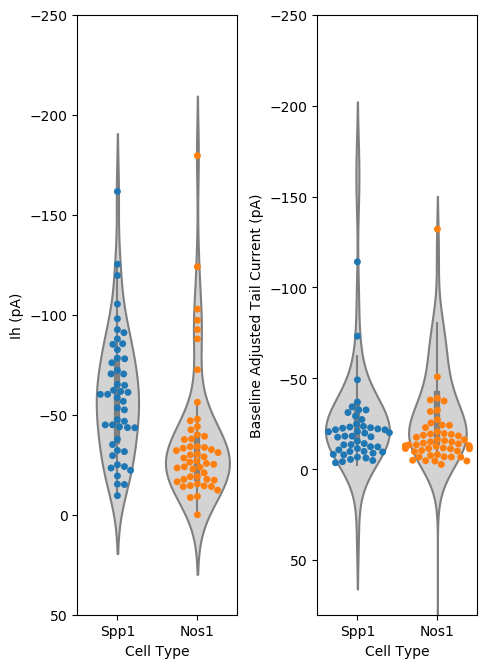

In [49]:
fig = plt.figure(figsize=(4,6), dpi = 100)

ax1 = fig.add_axes([0,0,0.4,1])
ax1.set_ylim(50,-250)


sns.violinplot(data = ZI_Ih_DF[ZI_Ih_DF['Sweep Number'] == 5], 
            x = 'Cell Type',
            y= 'Ih (pA)',
            ax = ax1,
            palette = ['lightgrey', 'lightgrey']
            )

sns.swarmplot(data = ZI_Ih_DF[ZI_Ih_DF['Sweep Number'] == 5], 
            x = 'Cell Type',
            y= 'Ih (pA)',
            ax = ax1
            )


ax2 = fig.add_axes([0.6,0,0.4,1])
ax2.set_ylim(80, -250)

sns.violinplot(data = ZI_Ih_DF[(ZI_Ih_DF['Sweep Number'] == 5) &
                               (ZI_Ih_DF['Baseline Adjusted Tail Current (pA)'] > -300)], 
            x = 'Cell Type',
            y=  'Baseline Adjusted Tail Current (pA)',
            ax = ax2,
            palette = ['lightgrey', 'lightgrey']
            )

sns.swarmplot(data = ZI_Ih_DF[ZI_Ih_DF['Sweep Number'] == 5 &
                               (ZI_Ih_DF['Baseline Adjusted Tail Current (pA)'] > -300)], 
            x = 'Cell Type',
            y=  'Baseline Adjusted Tail Current (pA)',
            ax = ax2,
            )

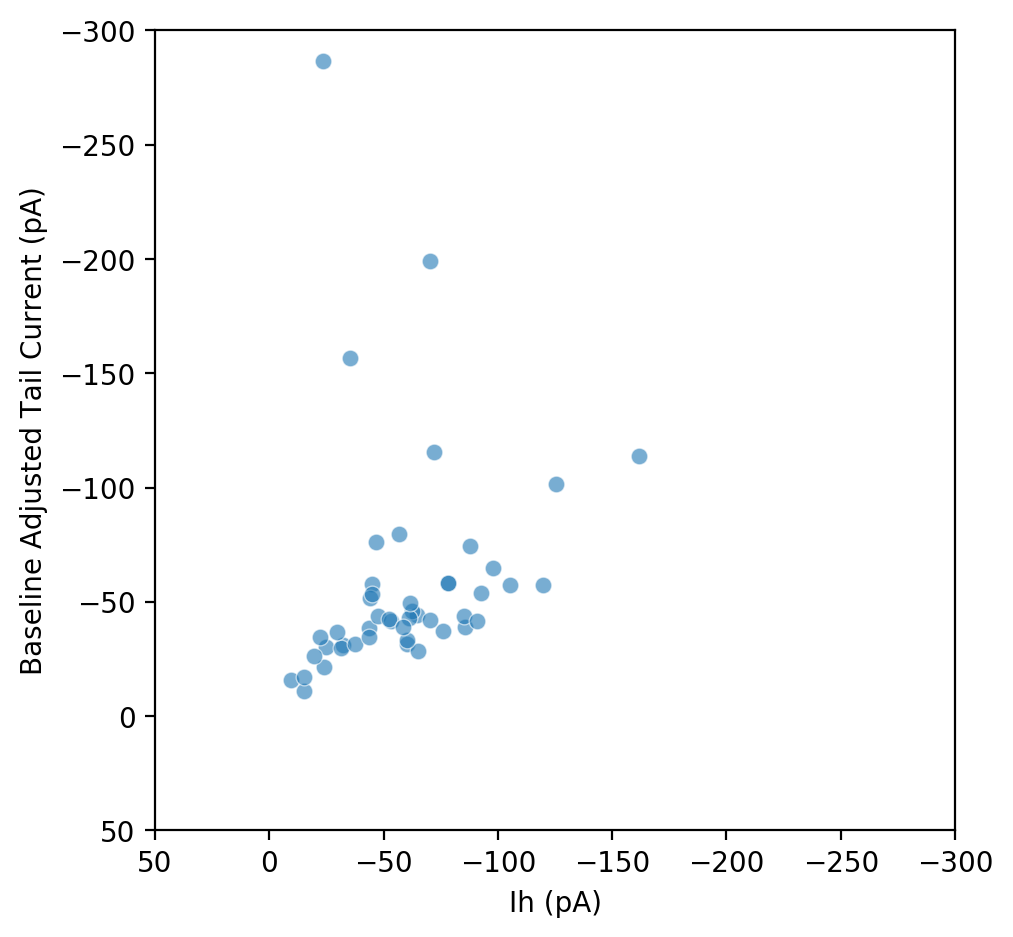

In [606]:
fig = plt.figure(figsize=(4,4), dpi = 200)

ax1 = fig.add_axes([0,0,1,1])
ax1.set_xlim(50, -300)
ax1.set_ylim(50, -300)


sns.scatterplot(data = ZI_Ih_DF[(ZI_Ih_DF['Sweep Number'] == 5) &
                               (ZI_Ih_DF['Baseline Adjusted Tail Current (pA)'] > -300) &
                               (ZI_Ih_DF['Cell Type'] == 'Spp1')],
               x = 'Ih (pA)',
               y = 'Baseline Adjusted Tail Current (pA)',
               #hue = 'Cell Type',
               alpha = 0.6)
                



In [593]:
ZI_Ih_DF.to_csv('ZI_Ih_091221.csv')

In [543]:
ZI_vsag_DF[ZI_vsag_DF['NeuronID'] == '2020-09-23/RK/N6'].

,level_0,index,Cell Type,Date (YmD),Mouse,Neuron,Filename,Protocol,Filepath,Sweep Number,Holding Current (pA),Current Step (pA),Pre-step Membrane Voltage (mV),Peak Negative Membrane Voltage (mV),Voltage Sag (mV),DATE,NeuronID
231,231,0,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,0,0.0,-50.0,-60.927681,-69.854736,0.646461,2020-09-23,2020-09-23/RK/N6
232,232,1,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,1,0.0,-100.0,-62.909187,-76.751709,0.958206,2020-09-23,2020-09-23/RK/N6
233,233,2,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,2,0.0,-150.0,-62.507954,-84.289551,2.344513,2020-09-23,2020-09-23/RK/N6
234,234,3,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,3,0.0,-200.0,-61.957409,-92.620850,4.953415,2020-09-23,2020-09-23/RK/N6
235,235,4,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,4,0.0,-250.0,-61.668205,-100.189209,7.601387,2020-09-23,2020-09-23/RK/N6
236,236,5,Spp1,20923,,RK/N6,20923004.abf,IC rebound IF,/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,5,0.0,-300.0,-61.949776,-105.865479,9.452881,2020-09-23,2020-09-23/RK/N6


In [ ]:
pd.concat(ZI_Ra_Rm_DF).reset_index().to_csv('ZI_Ra_Rm_072721.csv')
pd.concat(ZI_Ih_DF).reset_index().to_csv('ZI_Ih_DF_072721.csv')
pd.concat(ZI_vsag_DF).reset_index().to_csv('ZI_vsag_072721.csv')
pd.concat(ZI_RMP_DF).reset_index().to_csv('ZI_RMP_072721.csv')

# Example of Ih

In [596]:
#This Spp1 cell has actual Ih
ZI_Ih_DF[ZI_Ih_DF['NeuronID'] == '2020-09-23/RK/N6']

,level_0,index,Cell Type,Date (YmD),Mouse,Neuron,Filename,Protocol,Filepath,Sweep Number,Holding Voltage (mV),Voltage Step (mV),Ih_Ra (MOhms),Holding Current (pA),Total Current (pA),Ih (pA),Tail Current Peak (pA),Baseline Adjusted Tail Current (pA),DATE,NeuronID
269,269,0,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,1,-60.0,-70.0,9.972054,46.076351,-85.864258,-20.561829,14.038086,-32.038265,2020-09-23,2020-09-23/RK/N6
270,270,1,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,2,-60.0,-80.0,10.043471,43.711548,-178.601685,-35.097656,-3.662109,-47.373657,2020-09-23,2020-09-23/RK/N6
271,271,2,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,3,-60.0,-90.0,10.007582,36.301270,-277.793884,-48.011169,-5.187988,-41.489258,2020-09-23,2020-09-23/RK/N6
272,272,3,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,4,-60.0,-100.0,10.002194,23.292389,-389.531067,-79.983795,-23.193359,-46.485748,2020-09-23,2020-09-23/RK/N6
273,273,4,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,5,-60.0,-110.0,9.969217,11.166688,-516.292114,-105.345154,-46.081543,-57.248230,2020-09-23,2020-09-23/RK/N6
274,274,5,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,6,-60.0,-120.0,9.950980,2.640533,-641.306274,-121.392822,-59.509277,-62.149811,2020-09-23,2020-09-23/RK/N6
275,275,6,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,7,-60.0,-130.0,9.954606,-11.536559,-752.450256,-147.226562,-71.411133,-59.874573,2020-09-23,2020-09-23/RK/N6
276,276,7,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,8,-60.0,-140.0,9.946816,-18.443298,-861.311340,-142.144775,-79.956055,-61.512756,2020-09-23,2020-09-23/RK/N6
277,277,8,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,9,-60.0,-150.0,9.940364,-23.154144,-962.445190,-141.177979,-86.975098,-63.820953,2020-09-23,2020-09-23/RK/N6
278,278,9,Spp1,20923,,RK/N6,20923005.abf,VC episodic (ih),/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre...,10,-60.0,-160.0,10.027974,-27.895355,-1083.134644,-172.004150,-89.721680,-61.826324,2020-09-23,2020-09-23/RK/N6


In [517]:
ZI_Ih_DF.iloc[274]['Filepath']

'/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923005.abf'

In [555]:
xfm = [x for x in Spp1_data if x.abfFilePath == '/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923005.abf']
xfm
       

[ABFcore(abf="/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923005.abf", loadData=True)]

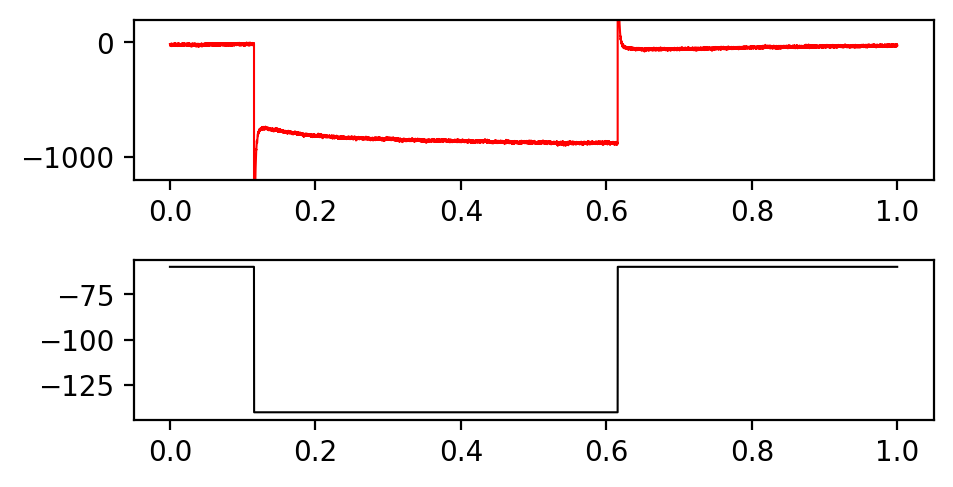

In [597]:
fig = plt.figure(figsize = (4,2), dpi =200)

abf = xfm[0]

ax1 = fig.add_axes([0,0,1,0.4])
ax2 = fig.add_axes([0,0.6,1,0.4])

ax2.set_ylim(-1200,200)

start = abf.sweepEpochs.p1s[3]+int(protocol.dataRate*0.005)
stop =  abf.sweepEpochs.p2s[4]

cm = sns.color_palette('cool', n_colors=len(abf.sweepList))
clist = [x/(len(abf.sweepList)) for x in abf.sweepList]
count = 0

abf.setSweep(7)

#print(spp1_ih_list[0].abfFilePath)
sns.lineplot(x=abf.sweepX,#[start:stop], 
             y=abf.sweepY,#[start:stop], 
             ax=ax2, 
             color = 'Red',
             size = 1,
             legend = False)


sns.lineplot(x=abf.sweepX, 
             y=abf.sweepC, 
             ax=ax1, 
             color = 'Black',
             size = 1,
             legend = False)
count += 1


# Example of Vsag

In [544]:
ZI_vsag_DF.iloc[236]['Filepath']

'/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923004.abf'

In [547]:
ygm = [x for x in Spp1_data if x.abfFilePath == '/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923004.abf']
ygm
       

[ABFcore(abf="/Volumes/ryanKast/RKDATA/PatchData/ZI/Spp1-Cre/AAV9-DIO-mCherry/2020/092320/RK/N6/20923004.abf", loadData=True)]

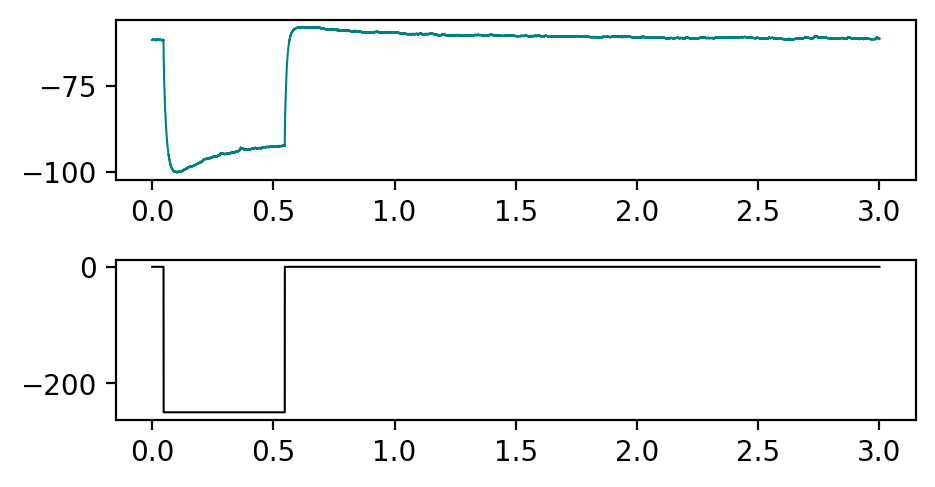

In [553]:
fig = plt.figure(figsize = (4,2), dpi =200)

abf = ygm[0]

ax1 = fig.add_axes([0,0,1,0.4])
ax2 = fig.add_axes([0,0.6,1,0.4])

#ax2.set_ylim(-1000,0)

#start = abf.sweepEpochs.p1s[3]+int(protocol.dataRate*0.005)
#stop =  abf.sweepEpochs.p2s[4]

cm = sns.color_palette('cool', n_colors=len(abf.sweepList))
clist = [x/(len(abf.sweepList)) for x in abf.sweepList]
count = 0

abf.setSweep(4)

#print(spp1_ih_list[0].abfFilePath)
sns.lineplot(x=abf.sweepX,#[start:stop], 
             y=abf.sweepY,#[start:stop], 
             ax=ax2, 
             color = 'Teal',
             size = 1,
             legend = False)


sns.lineplot(x=abf.sweepX, 
             y=abf.sweepC, 
             ax=ax1, 
             color = 'Black',
             size = 1,
             legend = False)
count += 1
